This is the second attempt, gunna do yolo for object detection and gunna use unet for semantic segmentaion

In [ ]:
from google.colab import drive
import os

# Google Colab Patch
use_colab = True
if use_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    import sys
    # ----------------------------------------
    dir = "/content/drive/MyDrive/Colab Notebooks/328/assignment4"
    # ----------------------------------------
    sys.path.append(dir)
from A4_utils import *

Mounted at /content/drive


laod in dataset

In [ ]:
import torch
from torch.utils.data.dataset import Dataset  # For custom data-sets
from torchvision import transforms
import torchvision
from skimage.io import imread
from PIL import Image
import torch.nn as nn
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

CLASSES= [
    '__background__', '0'
    '1', '2', '3',
    '4', '5', '6',
    '7', '8', '9'
]

Num_classes = 11

data_path = "/content/drive/MyDrive/Colab Notebooks/328/assignment4/mnistdd_rgb_train_valid/'

# training
train_image_path = data_path + 'train_X.npy'
train_label_path = data_path + 'train_Y.npy'
train_bboxes_path = data_path + 'train_bboxes.npy'
train_seg_path = data_path + 'train_seg.npy'

# validation
valid_image_path= data_path + 'valid_X.npy'
valid_label_path= data_path +'valid_Y.npy'
valid_bboxes_path = data_path +'valid_bboxes.npy'
valid_seg_path = data_path +'valid_seg.npy'


class CustomDataset(Dataset):
    def __init__(self, image_paths, label_paths, masks_paths, train=True):   # initial logic happens like transform
        self.images = np.load(image_paths)
        self.label =  np.load(label_paths)
        self.mask = np.load(masks_paths)
        self.transforms_image = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    def __getitem__(self, index):

         # Retrieve and preprocess a sample
        image = self.images[index].reshape(64, 64, 3)
        image = np.array(image, dtype=np.float32)
        image = image /255
        label = self.label[index]
        mask = self.mask[index].reshape(64, 64)

        image = self.transforms_image(image)
        mask = torch.from_numpy(mask).type(torch.LongTensor)
        return image, mask

    def __len__(self):  # return count of sample we have
        return len(self.images)

Define the unet model

In [ ]:
"""
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)
"""


class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)

        self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)

    def __call__(self, x):

        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)

        upconv3 = self.upconv3(conv3)

        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            #Sine(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            #Sine(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )
        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            #Sine(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            #Sine(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
                            )
        return expand

"""
class Decoder(nn.Module):
    def __init__(self, in_channel, mid_channel, out_channel):
        super(Decoder, self).__init__()

        self.conv = nn.Conv2d(in_channel, mid_channel, kernel_size=3, stride=1, padding=1) #keep ratio
        self.conv_trans = nn.ConvTranspose2d(mid_channel, out_channel, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = F.relu(self.conv(x), inplace=True)
        x = F.relu(self.conv_trans(x), inplace=True)
        return x

class Unet_resnet18(nn.Module):
    def __init__(self, n_classes):
        super(Unet_resnet18, self).__init__()

        #encoder
        self.encoder = models.resnet18(pretrained=True)

        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Sequential(self.encoder.conv1, self.encoder.bn1,
                                  self.encoder.relu, self.pool) #64
        self.conv2 = self.encoder.layer1 #64
        self.conv3 = self.encoder.layer2 #128
        self.conv4 = self.encoder.layer3 #256
        self.conv5 = self.encoder.layer4 #depth 512

        #center
        self.center = Decoder(512, 312, 256)

        #decoder
        self.decoder5 = Decoder(256+512, 256, 256)
        self.decoder4 = Decoder(256+256, 128, 128)
        self.decoder3 = Decoder(128+128, 64, 64)
        self.decoder2 = Decoder(64+64, 32, 32)
        self.decoder1 = Decoder(32, 16, 16)
        self.decoder0 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, stride=1, padding=1)

        self.final = nn.Conv2d(8, n_classes, kernel_size=1)

    def forward(self, x):

        #encoder
        conv1 = self.conv1(x) #64x64
        conv2 = self.conv2(conv1) #32x32
        conv3 = self.conv3(conv2) #16x16
        conv4 = self.conv4(conv3) #8x8
        conv5 = self.conv5(conv4) #4x4

        center = self.center(self.pool(conv5)) #4x4
        #decoder
        dec5 = self.decoder5(torch.cat([center, conv5], 1)) #8x8
        dec4 = self.decoder4(torch.cat([dec5, conv4], 1)) #16x16
        dec3 = self.decoder3(torch.cat([dec4, conv3], 1)) #32x32
        dec2 = self.decoder2(torch.cat([dec3, conv2], 1)) #64x64
        dec1 = self.decoder1(dec2) #128x128
        dec0 = F.relu(self.decoder0(dec1))

        final = torch.sigmoid(self.final(dec0))

        return final
"""

'\nclass Decoder(nn.Module):\n    def __init__(self, in_channel, mid_channel, out_channel):\n        super(Decoder, self).__init__()\n\n        self.conv = nn.Conv2d(in_channel, mid_channel, kernel_size=3, stride=1, padding=1) #keep ratio\n        self.conv_trans = nn.ConvTranspose2d(mid_channel, out_channel, kernel_size=4, stride=2, padding=1)\n\n    def forward(self, x):\n        x = F.relu(self.conv(x), inplace=True)\n        x = F.relu(self.conv_trans(x), inplace=True)\n        return x\n\nclass Unet_resnet18(nn.Module):\n    def __init__(self, n_classes):\n        super(Unet_resnet18, self).__init__()\n\n        #encoder\n        self.encoder = models.resnet18(pretrained=True)\n\n        self.pool = nn.MaxPool2d(2, 2)\n        self.conv1 = nn.Sequential(self.encoder.conv1, self.encoder.bn1,\n                                  self.encoder.relu, self.pool) #64\n        self.conv2 = self.encoder.layer1 #64\n        self.conv3 = self.encoder.layer2 #128\n        self.conv4 = self.enco

In [ ]:
def check_accuracy(loader, model, device="cuda"):

    num_correct = 0
    num_pixels = 0
    dice_score = 0
    images = np.load(data_path + "valid_X.npy")
    gt_truth = np.load(valid_seg_path)
    model.eval()

    with torch.no_grad():
      N = images.shape[0]
      pred_seg = np.empty((N, 4096), dtype=np.int32)
      device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

      transforms_image = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                              transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
      images = np.array(images, dtype=np.float32)
      images = torch.from_numpy(images)
      for i in range(N):
          # print(images[i].shape)
          image = images[i].reshape(64, 64, 3)
          image = np.array(image, dtype=np.float32)
          image = transforms_image(image)
          image = image.reshape(1, 3, 64, 64)
          image = image.to(device)
          pred_seg[i] = model(image).argmax(dim=1).flatten().cpu()

    acc = compute_segmentation_acc(pred_seg, gt_truth)
    print(
        f"Got with acc {acc*100 :.2f}"
    )
    model.train()

def train_function(data, model, optimizer, loss_fn, device):
    print('Entering into train function')
    loss_values = []
    data = tqdm(data)
    for index, batch in enumerate(data):
        X, y = batch
        X, y = X.to(device), y.to(device)
        preds = model(X)

        loss = loss_fn(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss.item()

def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

def compute_classification_acc(pred, gt):
    assert pred.shape == gt.shape
    return (pred == gt).astype(int).sum() / gt.size


def compute_segmentation_acc(pred, gt):
    # pred value should be from 0 to 10, where 10 is the background.
    assert pred.shape == gt.shape

    return (pred == gt).astype(int).sum() / gt.size

check to see some smaples

In [ ]:
train_dataset = CustomDataset(train_image_path, train_label_path, train_seg_path, train=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

valid_dataset = CustomDataset(valid_image_path, valid_label_path, valid_seg_path, train=False)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=16, shuffle=False)

images shape torch.Size([16, 3, 64, 64])
segmentation_masks shape torch.Size([16, 64, 64])


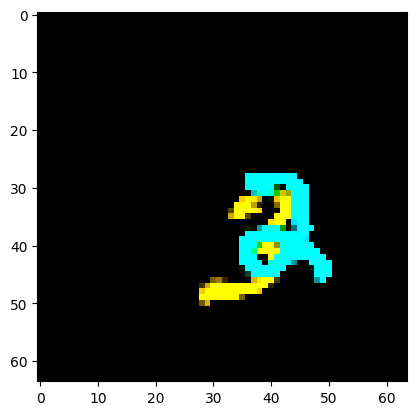

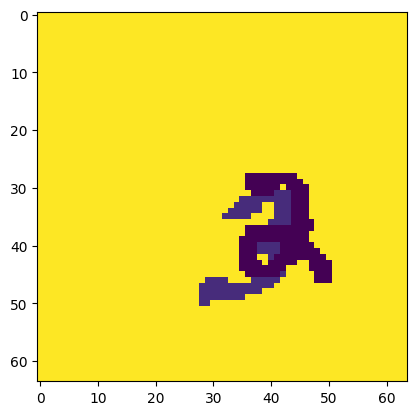

In [ ]:
import matplotlib.pyplot as plt

dataiter = enumerate(train_loader)
batch_idx, (images, target) = next(dataiter)

print(f"images shape {images.shape}")
# print(f"labels shape {target['labels'].shape}")
print(f"segmentation_masks shape {target.shape}")

plt.imshow(images[0].permute(1,2,0).data)
plt.show()
plt.imshow(target[0].data)
plt.show()

# plt.imshow(img_array, cmap='gray')
# plt.show()

In [ ]:
import torchvision.models as models
# Hyperparameters etc.
LEARNING_RATE = 1e-3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 100
NUM_EPOCHS = 20
weight_decay = 1e-4

PIN_MEMORY = True
MODEL_PATH = 'model.pth'
LOSS_VALS = []

backbone_model = models.resnet18(pretrained=True)

train_dataset = CustomDataset(train_image_path, train_label_path, train_seg_path, train=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

valid_dataset = CustomDataset(valid_image_path, valid_label_path, valid_seg_path, train=False)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)


model = UNET(3, 11).to(DEVICE).train()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay = weight_decay)


check_accuracy(valid_loader, model, device=DEVICE)

#Training the model for every epoch.
for e in range(NUM_EPOCHS):
    print(f'Epoch: {e}')
    loss_val = train_function(train_loader, model, optimizer, loss_fn, DEVICE)
    print(loss_val)
    LOSS_VALS.append(loss_val)
    torch.save({
        'model_state_dict': model.state_dict(),
        'optim_state_dict': optimizer.state_dict(),
        'epoch': e,
        'loss_values': LOSS_VALS
    }, MODEL_PATH)
    check_accuracy(valid_loader, model, device=DEVICE)
    print("Epoch completed and model successfully saved!")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 130MB/s]


Got with acc 23.50
Epoch: 0
Entering into train function


100%|██████████| 550/550 [00:43<00:00, 12.65it/s]


0.18367671966552734
Got with acc 94.19
Epoch completed and model successfully saved!
Epoch: 1
Entering into train function


100%|██████████| 550/550 [00:43<00:00, 12.68it/s]


0.16669391095638275
Got with acc 93.53
Epoch completed and model successfully saved!
Epoch: 2
Entering into train function


100%|██████████| 550/550 [00:43<00:00, 12.74it/s]


0.15431812405586243
Got with acc 93.26
Epoch completed and model successfully saved!
Epoch: 3
Entering into train function


100%|██████████| 550/550 [00:43<00:00, 12.69it/s]


0.10956863313913345
Got with acc 90.48
Epoch completed and model successfully saved!
Epoch: 4
Entering into train function


100%|██████████| 550/550 [00:43<00:00, 12.72it/s]


0.06745804101228714
Got with acc 92.90
Epoch completed and model successfully saved!
Epoch: 5
Entering into train function


100%|██████████| 550/550 [00:43<00:00, 12.77it/s]


0.024807685986161232
Got with acc 72.73
Epoch completed and model successfully saved!
Epoch: 6
Entering into train function


100%|██████████| 550/550 [00:43<00:00, 12.79it/s]


0.026005558669567108
Got with acc 73.56
Epoch completed and model successfully saved!
Epoch: 7
Entering into train function


100%|██████████| 550/550 [00:42<00:00, 12.81it/s]


0.025813942775130272
Got with acc 77.12
Epoch completed and model successfully saved!
Epoch: 8
Entering into train function


100%|██████████| 550/550 [00:42<00:00, 12.83it/s]


0.025479966774582863
Got with acc 81.38
Epoch completed and model successfully saved!
Epoch: 9
Entering into train function


100%|██████████| 550/550 [00:42<00:00, 12.83it/s]


0.019607778638601303
Got with acc 70.67
Epoch completed and model successfully saved!
Epoch: 10
Entering into train function


100%|██████████| 550/550 [00:42<00:00, 12.84it/s]


0.018883787095546722
Got with acc 75.84
Epoch completed and model successfully saved!
Epoch: 11
Entering into train function


100%|██████████| 550/550 [00:42<00:00, 12.85it/s]


0.01921348087489605
Got with acc 87.75
Epoch completed and model successfully saved!
Epoch: 12
Entering into train function


100%|██████████| 550/550 [00:42<00:00, 12.86it/s]


0.0206513162702322
Got with acc 90.65
Epoch completed and model successfully saved!
Epoch: 13
Entering into train function


100%|██████████| 550/550 [00:42<00:00, 12.85it/s]


0.016881898045539856
Got with acc 78.20
Epoch completed and model successfully saved!
Epoch: 14
Entering into train function


100%|██████████| 550/550 [00:42<00:00, 12.85it/s]


0.015909286215901375
Got with acc 79.53
Epoch completed and model successfully saved!
Epoch: 15
Entering into train function


100%|██████████| 550/550 [00:42<00:00, 12.87it/s]


0.017762182280421257
Got with acc 43.81
Epoch completed and model successfully saved!
Epoch: 16
Entering into train function


100%|██████████| 550/550 [00:42<00:00, 12.87it/s]


0.015655498951673508
Got with acc 71.92
Epoch completed and model successfully saved!
Epoch: 17
Entering into train function


100%|██████████| 550/550 [00:42<00:00, 12.86it/s]


0.015382515266537666
Got with acc 48.55
Epoch completed and model successfully saved!
Epoch: 18
Entering into train function


100%|██████████| 550/550 [00:42<00:00, 12.85it/s]


0.014518490992486477


KeyboardInterrupt: ignored

In [ ]:
!python3 "gdrive/MyDrive/Colab Notebooks/328/assignment4/A4_main.py"

testing with some output

In [ ]:
images = np.load(data_path + "valid_X.npy")
gt_truth = np.load(valid_seg_path)

N = images.shape[0]
pred_seg = np.empty((N, 4096), dtype=np.int32)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

transforms_image = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
images = np.array(images, dtype=np.float32)
images = torch.from_numpy(images)
for i in range(N):
    # print(images[i].shape)
    image = images[i].reshape(64, 64, 3)
    image = np.array(image, dtype=np.float32)
    image = transforms_image(image)
    image = image.reshape(1, 3, 64, 64)
    image = image.to(device)
    pred_seg[i] = model(image).argmax(dim=1).flatten().cpu()

acc = compute_segmentation_acc(pred_seg, gt_truth)

print(f"accury = {acc}")
image = images[0].reshape(64, 64, 3)
image = np.array(image, dtype=np.float32)
image = transforms_image(image)

predecited_mask = torch.from_numpy(pred_seg[0])
predecited_mask = predecited_mask.reshape(64, 64)
# plt.imshow(image.permute(1,2,0).data)
# plt.show()
print(predecited_mask.data)
plt.imshow(predecited_mask.data)
plt.show()



A4_main.py

In [ ]:
import numpy as np
import torch
import os
import shutil


def detect_and_segment(images):
    """

    :param np.ndarray images: N x 12288 array containing N 64x64x3 images flattened into vectors
    :return: np.ndarray, np.ndarray
    """
    N = images.shape[0]

    # pred_class: Your predicted labels for the 2 digits, shape [N, 2]
    pred_class = np.empty((N, 2), dtype=np.int32)
    # pred_bboxes: Your predicted bboxes for 2 digits, shape [N, 2, 4]
    pred_bboxes = np.empty((N, 2, 4), dtype=np.float64)
    # pred_seg: Your predicted segmentation for the image, shape [N, 4096]
    pred_seg = np.empty((N, 4096), dtype=np.int32)

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    # pred_seg: Your predicted segmentation for the image, shape [N, 4096]
    pred_seg = np.empty((N, 4096), dtype=np.int32)

    model = UNET(3, 11).to(device)
    checkpoint = torch.load("saved_model.pth")
    model.load_state_dict(checkpoint["model_state_dict"])

    transforms_image = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    images = np.array(images, dtype=np.float32)
    images = torch.from_numpy(images)

    for i in range(N):
        # print(images[i].shape)
        image = images[i].reshape(64, 64, 3)
        image = np.array(image, dtype=np.float32)
        image = transforms_image(image)
        image = image.reshape(1, 3, 64, 64)
        image = image.to(device)
        pred_seg[i] = model(image).argmax(dim=1).flatten().cpu()


    # add your code here to fill in pred_class and pred_bboxes

    return pred_class, pred_bboxes, pred_seg

In [ ]:
import os.path
import timeit
import numpy as np
from skimage.draw import polygon


def compute_classification_acc(pred, gt):
    assert pred.shape == gt.shape
    return (pred == gt).astype(int).sum() / gt.size


def compute_segmentation_acc(pred, gt):
    # pred value should be from 0 to 10, where 10 is the background.
    assert pred.shape == gt.shape

    return (pred == gt).astype(int).sum() / gt.size


def get_iou(bbox_pred, bbox_gt, L_pred, L_gt):
    """all pixel coordinates within the prediction bounding box"""
    rr, cc = polygon([bbox_pred[0], bbox_pred[0], bbox_pred[2], bbox_pred[2]],
                     [bbox_pred[1], bbox_pred[3], bbox_pred[3], bbox_pred[1]], [64, 64])
    L_pred[rr, cc] = 1

    """all pixel coordinates within the GT bounding box"""
    rr, cc = polygon([bbox_gt[0], bbox_gt[0], bbox_gt[2], bbox_gt[2]],
                     [bbox_gt[1], bbox_gt[3], bbox_gt[3], bbox_gt[1]], [64, 64])
    L_gt[rr, cc] = 1

    L_sum = L_pred + L_gt
    intersection = np.sum(L_sum == 2)
    union = np.sum(L_sum >= 1)

    iou = intersection / union

    L_pred[:, :] = 0
    L_gt[:, :] = 0

    return iou


def compute_mean_iou(bboxes_pred, bboxes_gt, classes_pred, classes_gt):
    """

    :param bboxes_pred: predicted bounding boxes, shape=(n_images,2,4)
    :param bboxes_gt: ground truth bounding boxes, shape=(n_images,2,4)
    :param classes_pred: predicted classes, shape=(n_images,2)
    :param classes_gt: ground truth classes, shape=(n_images,2)
    :return:
    """

    n_images = np.shape(bboxes_gt)[0]
    L_pred = np.zeros((64, 64))
    L_gt = np.zeros((64, 64))
    iou_sum = 0.0
    for i in range(n_images):
        iou1 = get_iou(bboxes_pred[i, 0, :], bboxes_gt[i, 0, :], L_pred, L_gt)
        iou2 = get_iou(bboxes_pred[i, 1, :], bboxes_gt[i, 1, :], L_pred, L_gt)

        iou_sum1 = iou1 + iou2

        if classes_pred[i, 0] == classes_pred[i, 1] and classes_gt[i, 0] == classes_gt[i, 1]:
            iou1 = get_iou(bboxes_pred[i, 0, :], bboxes_gt[i, 1, :], L_pred, L_gt)
            iou2 = get_iou(bboxes_pred[i, 1, :], bboxes_gt[i, 0, :], L_pred, L_gt)

            iou_sum2 = iou1 + iou2

            if iou_sum2 > iou_sum1:
                iou_sum1 = iou_sum2

        iou_sum += iou_sum1

    mean_iou = iou_sum / (2. * n_images)

    return mean_iou


class Params:
    def __init__(self):
        # self.prefix = "test"
        self.prefix = "valid"
        # self.prefix = "train"
        self.load = 1
        self.save = 1
        self.load_path = 'saved_preds.npz'
        self.vis = 0
        self.vis_size = (300, 300)
        self.show_det = 0
        self.show_seg = 1

        self.speed_thresh = 10
        self.acc_thresh = (0.7, 0.98)
        self.iou_thresh = (0.7, 0.98)
        self.seg_thresh = (0.7, 0.98)

        self.class_cols = {
            0: 'red',
            1: 'green',
            2: 'blue',
            3: 'magenta',
            4: 'cyan',
            5: 'yellow',
            6: 'purple',
            7: 'forest_green',
            8: 'orange',
            9: 'white',
            10: 'black',
        }


def compute_score(res, thresh):
    min_thres, max_thres = thresh

    if res < min_thres:
        score = 0.0
    elif res > max_thres:
        score = 100.0
    else:
        score = float(res - min_thres) / (max_thres - min_thres) * 100
    return score


def main():
    params = Params()

    try:
        import paramparse
    except ImportError:
        pass
    else:
        paramparse.process(params)

    prefix = params.prefix

    images = np.load(data_path+prefix + "_X.npy")
    gt_classes = np.load(data_path+prefix + "_Y.npy")
    gt_bboxes = np.load(data_path+prefix + "_bboxes.npy")
    gt_seg = np.load(data_path+prefix + "_seg.npy")

    n_images = images.shape[0]

    if params.load and os.path.exists(params.load_path):
        print(f'loading predictions from {params.load_path}')
        saved_preds = np.load(params.load_path)
        pred_classes = saved_preds['pred_classes']
        pred_bboxes = saved_preds['pred_bboxes']
        pred_seg = saved_preds['pred_seg']

        test_time = test_speed = 0
    else:
        print(f'running prediction on {n_images} {prefix} images')
        start_t = timeit.default_timer()
        pred_classes, pred_bboxes, pred_seg = detect_and_segment(images)
        end_t = timeit.default_timer()
        test_time = end_t - start_t
        assert test_time > 0, "test_time cannot be 0"
        test_speed = float(n_images) / test_time

        if params.save:
            np.savez_compressed(params.load_path, pred_classes=pred_classes, pred_bboxes=pred_bboxes, pred_seg=pred_seg)

    cls_acc = compute_classification_acc(pred_classes, gt_classes)
    iou = compute_mean_iou(pred_bboxes, gt_bboxes, pred_classes, gt_classes)
    seg_acc = compute_segmentation_acc(pred_seg, gt_seg)

    acc_score = compute_score(cls_acc, params.acc_thresh)
    iou_score = 0 # compute_score(iou, params.iou_thresh)
    seg_score = compute_score(seg_acc, params.seg_thresh)

    if test_speed < params.speed_thresh:
        overall_score = 0
    else:
        overall_score = ((iou_score + acc_score) / 2. + seg_score) / 2.

    print(f"Classification Accuracy: {cls_acc*100:.3f} %")
    print(f"Detection IOU: {iou*100:.3f} %")
    print(f"Segmentation Accuracy: {seg_acc*100:.3f} %")

    print(f"Test time: {test_time:.3f} seconds")
    print(f"Test speed: {test_speed:.3f} images / second")

    print(f"Classification Score: {acc_score:.3f}")
    print(f"IOU Score: {iou_score:.3f}")
    print(f"Segmentation Score: {seg_score:.3f}")
    print(f"Overall Score: {overall_score:.3f}")

    if not params.vis:
        return

    import cv2
    from A4_utils import vis_bboxes, vis_seg, annotate

    print('press spacebar to toggle pause and escape to quit')
    pause_after_frame = 1
    for img_id in range(n_images):
        src_img = images[img_id, ...].squeeze()
        src_img = src_img.reshape((64, 64, 3)).astype(np.uint8)

        vis_img = np.copy(src_img)

        bbox_1 = gt_bboxes[img_id, 0, :].squeeze().astype(np.int32)
        bbox_2 = gt_bboxes[img_id, 1, :].squeeze().astype(np.int32)
        y1, y2 = gt_classes[img_id, ...].squeeze()
        gt_classes[img_id, ...].squeeze()
        vis_img = vis_bboxes(vis_img, bbox_1, bbox_2, y1, y2, params.vis_size)
        vis_img_seg_gt = vis_seg(src_img, gt_seg, img_id, params.class_cols, params.vis_size)

        vis_img_list = [vis_img, vis_img_seg_gt]
        vis_img_labels = ['gt det', 'gt seg']

        if params.show_det:
            vis_img_det = np.copy(src_img)
            bbox_1 = pred_bboxes[img_id, 0, :].squeeze().astype(np.int32)
            bbox_2 = pred_bboxes[img_id, 1, :].squeeze().astype(np.int32)
            y1, y2 = pred_classes[img_id, ...].squeeze()
            gt_classes[img_id, ...].squeeze()
            vis_img_det = vis_bboxes(vis_img_det, bbox_1, bbox_2, y1, y2, params.vis_size)
            vis_img_list.append(vis_img_det)
            vis_img_labels.append('pred det')

        if params.show_seg:
            vis_img_seg = vis_seg(src_img, pred_seg, img_id, params.class_cols, params.vis_size)
            vis_img_list.append(vis_img_seg)
            vis_img_labels.append('pred seg')

        vis_img = annotate(vis_img_list,
                           text=f'image {img_id}',
                           img_labels=vis_img_labels, grid_size=(1, -1))
        cv2.imshow('vis_img', vis_img)

        key = cv2.waitKey(1 - pause_after_frame)
        if key == 27:
            return
        elif key == 32:
            pause_after_frame = 1 - pause_after_frame


if __name__ == '__main__':
    main()